# Experiments
## Bioit set - basic ARTM with regularizers

In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt
import pandas as pd
import artm

/tmp/ipykernel_803/2868503476.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
artm.version()

'0.9.2'

In [50]:
#Preparing input
input_folder = '../Data/bioit_set/'
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}bioit_set_2_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_2.txt',
    vocab_file_path=f'{input_folder}vocab_2.txt',
    symmetric_cooc_values=True)


In [4]:
#defining regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

new_regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
]
#hyperparameters
num_topics = 5
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict, 
        topic_names=topic_names)
         ]

#creating the model
model_artm = artm.ARTM(topic_names=topic_names, 
                       class_ids = {"@default_class": 1.0, "@bigram": 1.0},
                       cache_theta=True,
                       scores=scores,
                       regularizers=regularizers,
                        num_topics = num_topics)

#EM hyperparameters
num_collection_passes = 25
#varying regularization coefficients
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -20
# model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

In [5]:
#Fitting the model
model_artm.initialize(dictionary = cooc_dict)
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=num_collection_passes)

In [6]:
def print_measures(model:list):          
    print('Sparsity Phi: {0:.3f} '.format(
        model.score_tracker['SparsityPhiScore'].last_value))

    print('Sparsity Theta: {0:.3f}'.format(
        model.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f}'.format(
        model.score_tracker['TopicKernelScore'].last_average_purity))
    
    plt.plot(range(len(model.score_tracker['SparsityPhiScore'].value)),
         model.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
    plt.title('Plot of Phi Sparsity Score by Iteration')
    plt.xlabel('Iterations count')
    plt.ylabel('Phi sparsity')
    plt.show()
    
    plt.plot(range(len(model.score_tracker['SparsityThetaScore'].value)),
             model.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
    plt.title('Plot of Theta Sparsity Score by Iteration')
    plt.xlabel('Iterations count')
    plt.ylabel('Theta sparsity')
    plt.show()
    if type(model) == artm.artm_model.ARTM:
        df = pd.DataFrame.from_dict(model.score_tracker['TopicKernelScore'].contrast).transpose()
        plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel contrast')
        plt.title('Boxplot of Kernel Contrast across topics by Iteration')
        plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if necessary
        plt.show()

        df = pd.DataFrame.from_dict(model.score_tracker['TopicKernelScore'].purity).transpose()
        plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel purity')
        plt.title('Boxplot of Kernel Purity across topics by Iteration')
        plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if necessary
        plt.show()

        df = pd.DataFrame.from_dict(model.score_tracker['TopKernelScore Coherence'].coherence).transpose()
        plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel coherence')
        plt.title('Boxplot of Kernel Coherence across topics by Iteration')
        plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if necessary
        plt.show()
    elif type(model) == artm.hierarchy_utils.ARTM_Level:
        df = pd.DataFrame.from_dict(model._score_tracker['TopicKernelScore'].contrast).transpose()
        plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel contrast')
        plt.title('Boxplot of Kernel Contrast across topics by Iteration')
        plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if necessary
        plt.show()

        df = pd.DataFrame.from_dict(model._score_tracker['TopicKernelScore'].purity).transpose()
        plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel purity')
        plt.title('Boxplot of Kernel Purity across topics by Iteration')
        plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if necessary
        plt.show()

        df = pd.DataFrame.from_dict(model._score_tracker['TopKernelScore Coherence'].coherence).transpose()
        plt.figure(figsize=(6, 6))
        df.boxplot()
        plt.xlabel('Iteration')
        plt.ylabel('Kernel coherence')
        plt.title('Boxplot of Kernel Coherence across topics by Iteration')
        plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if necessary
        plt.show()

Sparsity Phi: 0.781 
Sparsity Theta: 0.559
Kernel contrast: 0.940
Kernel purity: 0.937


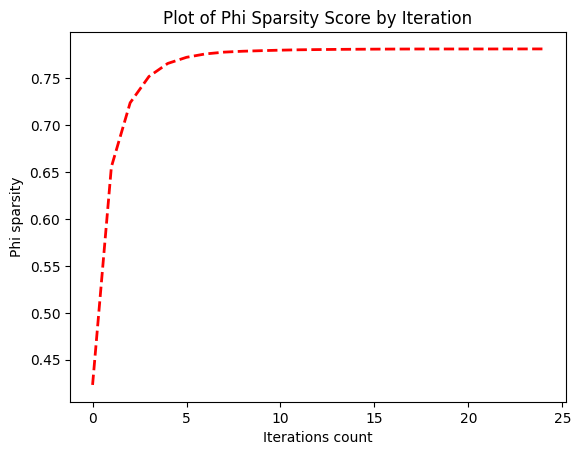

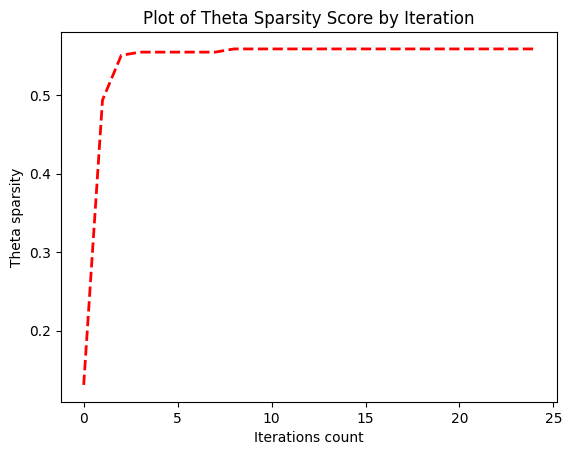

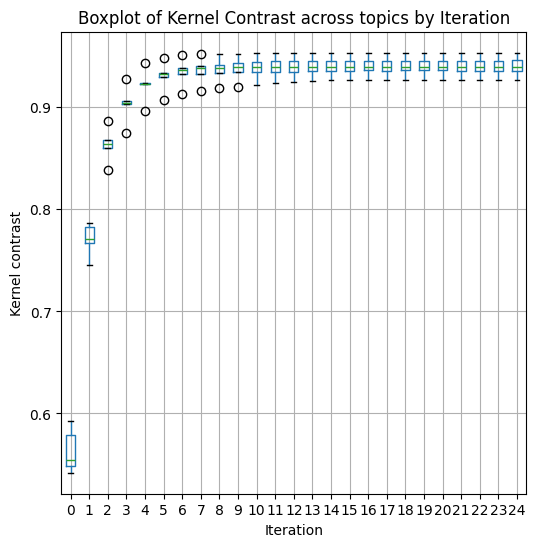

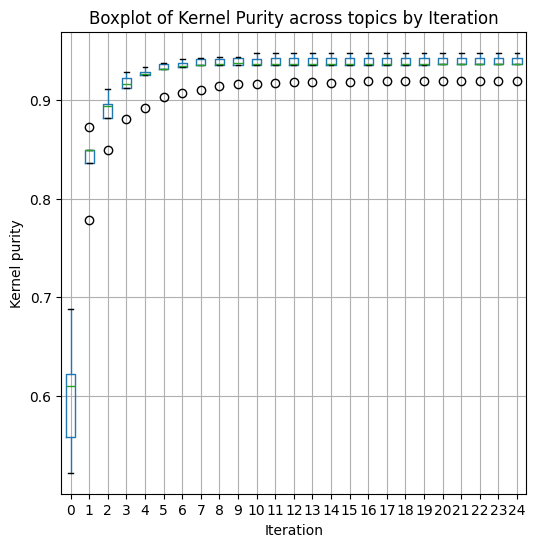

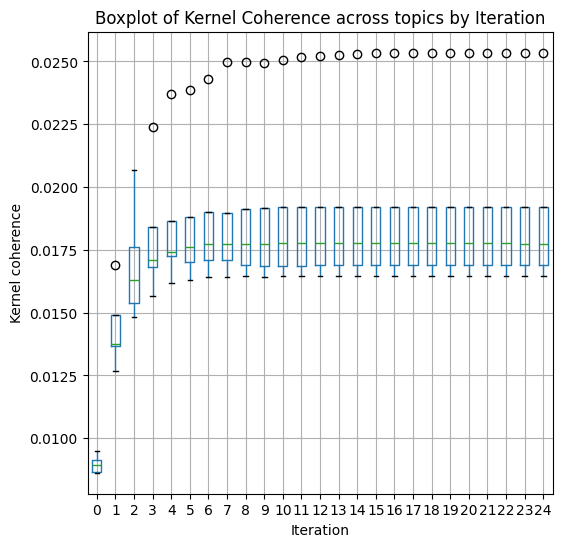

In [7]:
print_measures(model_artm)

In [8]:
for topic_name in model_artm.topic_names:
    print(
        topic_name + ': ', model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0:  ['wgs_data', 'variant_call', 'amino_acid', 'genom_sequenc', 'mash_distanc', 'per_cent', 'refer_genom', 'metagenom_studi', 'variant_caller', 'sequenc_data']
topic_1:  ['cell_data', 'nat_method', 'analysi_data', 'data_cell', 'singl_cell', 'gene_express', 'method_data', 'nat_biotechnol', 'data_analysi', 'cell_type']
topic_2:  ['read_align', 'align_algorithm', 'algorithm_read', 'dna_hash', 'hash_dna', 'read_contig', 'author_manuscript', 'align_read', 'read_length', 'sequenc_read']
topic_3:  ['deep_learn', 'liquid_biopsi', 'data_set', 'lung_cancer', 'circul_tumor', 'neural_network', 'ion_torrent', 'tumor_dna', 'miss_data', 'nucleic_acid']
topic_4:  ['sequenc_data', 'bruijn_graph', 'refer_genom', 'genom_sequenc', 'short_read', 'dna_sequenc', 'assembl_graph', 'sequenc_dna', 'metagenom_analysi', 'sequenc_genom']


In [9]:
print(model_artm.phi_)
print(model_artm.get_theta())

                  topic_0  topic_1   topic_2   topic_3  topic_4
across_cluster   0.000000      0.0  0.000127  0.000000      0.0
across_genom     0.000240      0.0  0.000242  0.000080      0.0
across_hmp       0.000093      0.0  0.000000  0.000000      0.0
across_sampl     0.000000      0.0  0.000911  0.000477      0.0
adjust_rand      0.000000      0.0  0.000921  0.000000      0.0
...                   ...      ...       ...       ...      ...
vertic_also      0.000000      0.0  0.000286  0.000000      0.0
vertic_harmon    0.000000      0.0  0.000000  0.000081      0.0
visual_grapetre  0.000000      0.0  0.000000  0.000081      0.0
visual_minimum   0.000000      0.0  0.000000  0.000181      0.0
visual_sts       0.000000      0.0  0.000000  0.000181      0.0

[18780 rows x 5 columns]
               0         1    2         3             4         5         6   \
topic_0  0.186616  0.000000  0.0  0.000000  0.000000e+00  0.163270  0.000000   
topic_1  0.000000  0.012718  1.0  0.830683  0.

## NLP set - basic ARTM with regularizers

In [10]:
#Preparing input
input_folder = '../Data/nlp_set/'
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_2_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_2.txt',
    vocab_file_path=f'{input_folder}vocab_2.txt',
    symmetric_cooc_values=True)


In [11]:
#defining regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

new_regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
]
#hyperparameters
num_topics = 5
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict, 
        topic_names=topic_names)
         ]

#creating the model
model_artm = artm.ARTM(
                       topic_names=topic_names, 
                       class_ids = {"@default_class": 1.0, "@bigram": 1.0},
                       cache_theta=True,
                       scores=scores,
                       regularizers=regularizers,
                        num_topics = num_topics)

#EM hyperparameters
num_collection_passes = 25
#varying regularization coefficients
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -20
# model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5

In [12]:
#Fitting the model
model_artm.initialize(dictionary = cooc_dict)
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=num_collection_passes)

Sparsity Phi: 0.778 
Sparsity Theta: 0.504
Kernel contrast: 0.937
Kernel purity: 0.931


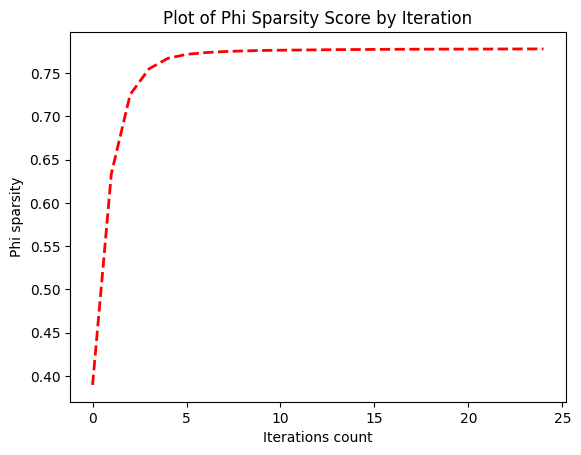

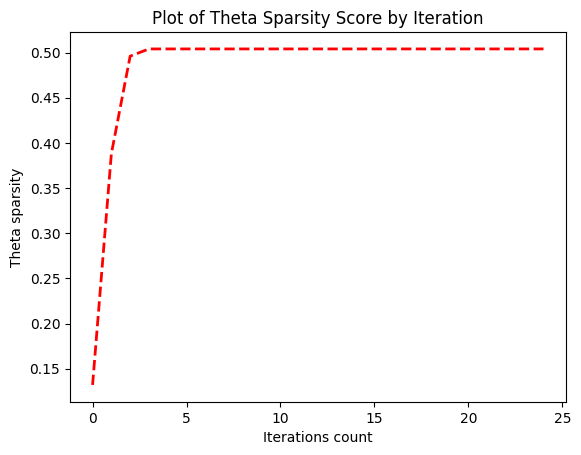

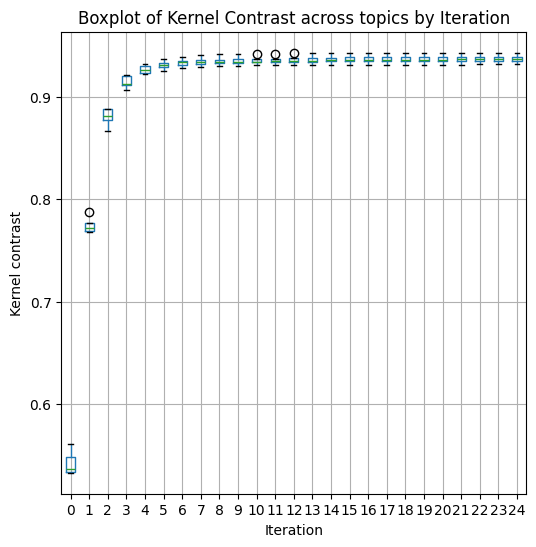

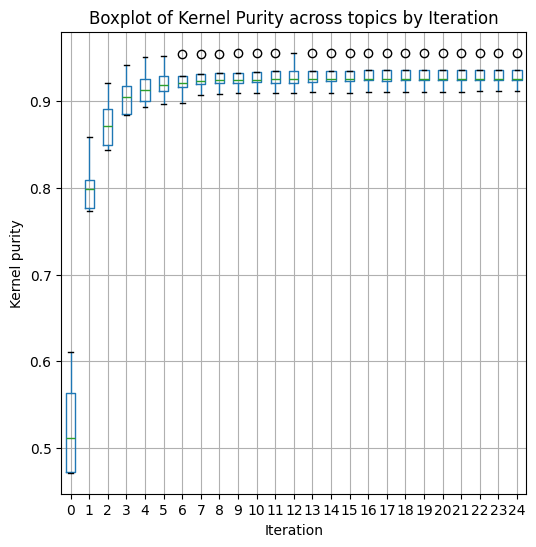

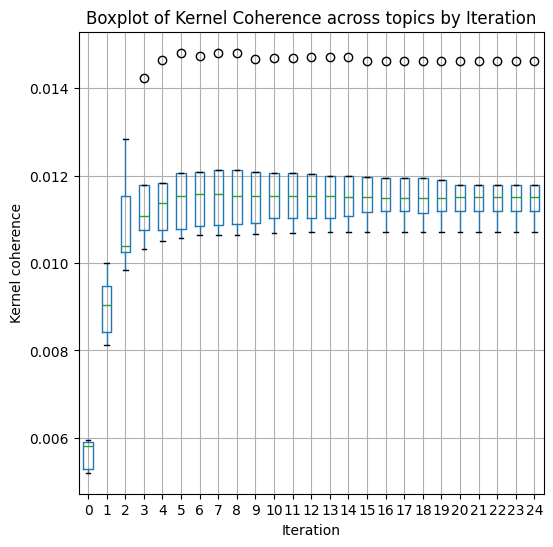

In [13]:
print_measures(model_artm)

In [14]:
for topic_name in model_artm.topic_names:
    print(
        topic_name + ': ', model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0:  ['associ_comput', 'intern_confer', 'comput_linguist', 'spam_detect', 'social_spam', 'citat_context', 'social_network', 'prefilt_model', 'proceed_intern', 'proceed_confer']
topic_1:  ['knowledg_sourc', 'twitter_data', 'data_set', 'topic_model', 'document_cluster', 'knowledg_graph', 'qualiti_control', 'cluster_method', 'cluster_topic', 'argument_mine']
topic_2:  ['clinic_trial', 'social_media', 'atom_chang', 'problem_solut', 'onlin_news', 'word_embed', 'text_classif', 'languag_model', 'themat_area', 'institut_technolog']
topic_3:  ['comput_linguist', 'natur_languag', 'languag_process', 'proceed_confer', 'concept_extract', 'associ_comput', 'intern_confer', 'proceed_intern', 'word_sens', 'anaphora_resolut']
topic_4:  ['network_embed', 'patent_text', 'represent_learn', 'machin_learn', 'intern_confer', 'social_distanc', 'model_combin', 'embed_network', 'text_classif', 'learn_represent']


In [15]:
print(model_artm.phi_)
print(model_artm.get_theta())

                    topic_0   topic_1   topic_2  topic_3   topic_4
afu_case                0.0  0.000000  0.000113      0.0  0.000000
afu_error               0.0  0.000150  0.000000      0.0  0.000000
aim_argument            0.0  0.000000  0.000238      0.0  0.000000
algorithm_argument      0.0  0.000150  0.000000      0.0  0.000000
algorithm_classi        0.0  0.000067  0.000000      0.0  0.000000
...                     ...       ...       ...      ...       ...
ﬁcﬂow_approach          0.0  0.000000  0.000000      0.0  0.000067
ﬁcﬂow_method            0.0  0.000067  0.000000      0.0  0.000000
ﬁcﬂow_network           0.0  0.000150  0.000000      0.0  0.000000
ﬁcﬂow_predict           0.0  0.000234  0.000000      0.0  0.000000
ﬁcﬂow_studi             0.0  0.000067  0.000000      0.0  0.000000

[30393 rows x 5 columns]
               0         1         2         3         4         5       6   \
topic_0  0.000000  0.131414  0.658272  0.000000  0.138329  0.000000  0.1176   
topic_1  0.8

# Hierarchical topic models

## Bioit set - hARTM with regularizers

In [16]:
#Preparing input
input_folder = '../Data/nlp_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [17]:
#Define regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

In [18]:
#Define quality scores
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

In [19]:
#Define the model hierarchy
model_artm = artm.hARTM(
    regularizers = regularizers,
    scores=scores,
    cache_theta=True
)

In [20]:
#Add root level
level1 = model_artm.add_level(
    num_topics=5,
    
)

In [21]:
#Initialize
level1.initialize(dictionary = cooc_dict)

In [22]:
#Add first level
level2 = model_artm.add_level(
    num_topics=10
)

In [23]:
#Initialize
level2.initialize(dictionary = cooc_dict)

In [24]:
#Fit
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=25)

In [25]:
print(model_artm.get_level(0).phi_)
print(model_artm.get_level(0).get_theta())

            topic_0   topic_1   topic_2   topic_3   topic_4
afu        0.000176  0.000000  0.000000  0.000000  0.000000
aim        0.000200  0.000205  0.000000  0.000000  0.000000
algorithm  0.002678  0.002191  0.003103  0.000000  0.006489
also       0.001248  0.008887  0.001471  0.001661  0.003873
annot      0.003088  0.008065  0.009003  0.000000  0.000579
...             ...       ...       ...       ...       ...
theta      0.000000  0.000000  0.000000  0.000000  0.000256
traf       0.000000  0.000000  0.000000  0.000000  0.005643
transport  0.000000  0.000000  0.000000  0.000000  0.003738
vehicular  0.000000  0.000000  0.000000  0.000000  0.000256
ﬁcﬂow      0.000000  0.000000  0.000000  0.000000  0.000519

[1995 rows x 5 columns]
               0         1         2         3         4         5         6   \
topic_0  0.985419  0.946272  0.266091  0.025096  0.001626  0.001511  0.018233   
topic_1  0.007712  0.000000  0.449225  0.003949  0.049466  0.000000  0.181630   
topic_2  0.0

Sparsity Phi: 0.835 
Sparsity Theta: 0.449
Kernel contrast: 0.814
Kernel purity: 0.831


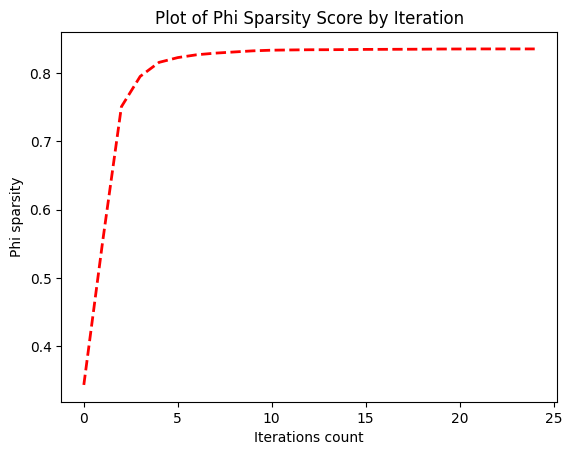

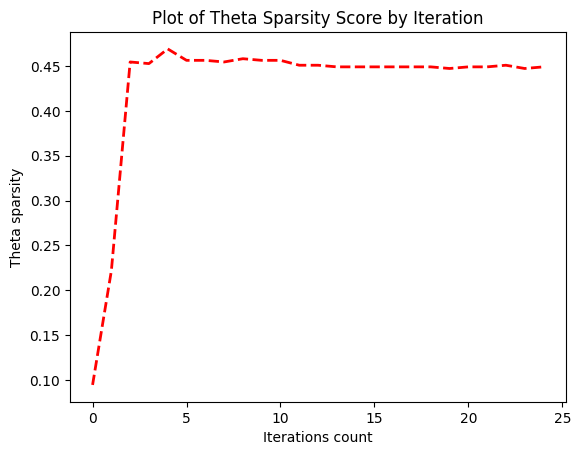

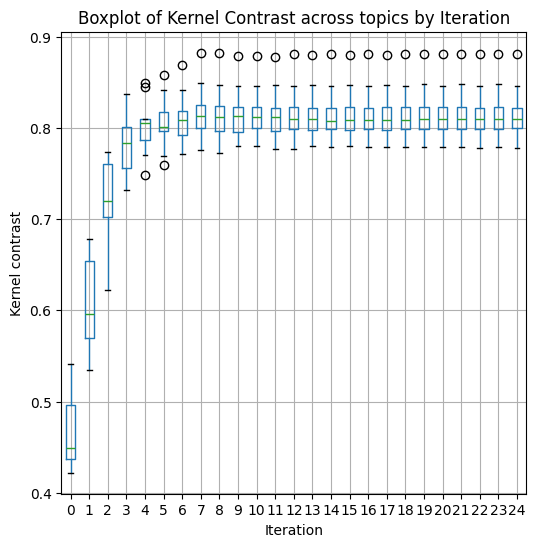

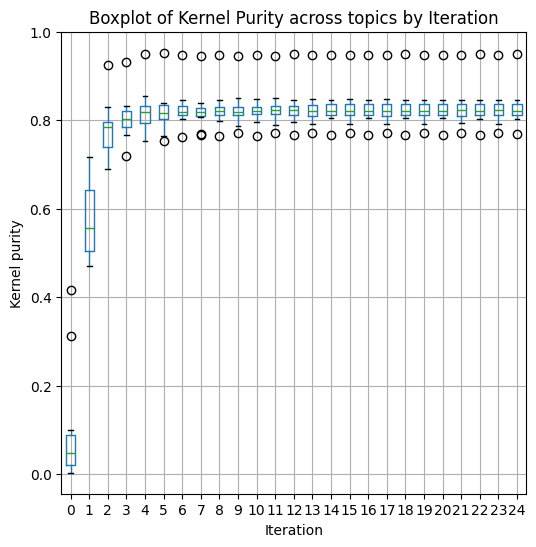

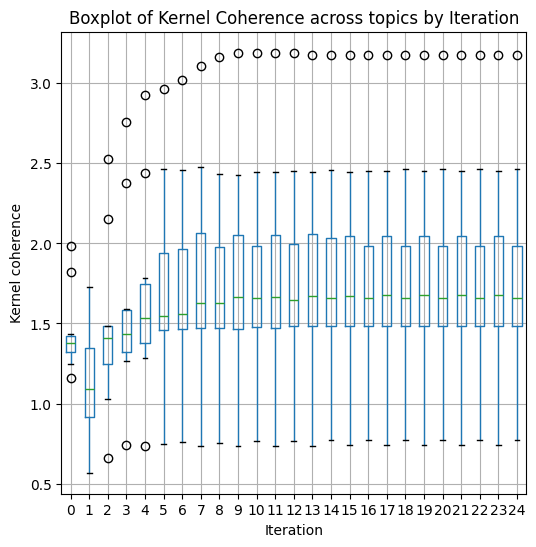

In [26]:
#The way to access score tracker for hARTM models
print_measures(model_artm.get_level(0))

## Bioit set - hARTM with regularizers

In [27]:
#Preparing input
input_folder = '../Data/bioit_set/'
n_gram_value = 2
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}bioit_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [28]:
#Define regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=1.5e+5),
]

In [29]:
#Define quality scores
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict)
         ]

In [30]:
#Define the model hierarchy
model_artm = artm.hARTM(
    regularizers = regularizers,
    scores=scores,
    cache_theta=True
)

In [31]:
#Add root level
level1 = model_artm.add_level(
    num_topics=5,
    
)

In [32]:
#Initialize
level1.initialize(dictionary = cooc_dict)

In [33]:
#Add first level
level2 = model_artm.add_level(
    num_topics=10
)

In [34]:
#Initialize
level2.initialize(dictionary = cooc_dict)

In [35]:
#Fit
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=25)

In [36]:
print(model_artm.get_level(0).phi_)
print(model_artm.get_level(0).get_theta())

                 topic_0   topic_1  topic_2  topic_3   topic_4
across_cluster       0.0  0.000000  0.00000      0.0  0.000092
across_genom         0.0  0.000000  0.00000      0.0  0.000499
across_hmp           0.0  0.000000  0.00000      0.0  0.000092
across_sampl         0.0  0.000481  0.00000      0.0  0.000655
adjust_rand          0.0  0.000000  0.00000      0.0  0.000601
...                  ...       ...      ...      ...       ...
vertic_also          0.0  0.000000  0.00021      0.0  0.000000
vertic_harmon        0.0  0.000000  0.00010      0.0  0.000000
visual_grapetre      0.0  0.000000  0.00010      0.0  0.000000
visual_minimum       0.0  0.000000  0.00021      0.0  0.000000
visual_sts           0.0  0.000000  0.00021      0.0  0.000000

[18780 rows x 5 columns]
               0         1         2         3         4         5         6   \
topic_0  0.000000  0.944399  0.000000  0.000000  0.000000  0.792883  0.025198   
topic_1  0.000000  0.003219  0.086161  0.006229  0.00986

In [47]:
for topic_name in model_artm.get_level(0).topic_names:
    print(topic_name + ': ')
    print(model_artm.get_level(0)._score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['align_read', 'align_algorithm', 'algorithm_read', 'dna_hash', 'hash_dna', 'sequenc_read', 'read_length', 'bipolar_cell', 'variant_call', 'metagenom_studi']
topic_1: 
['deep_learn', 'lung_cancer', 'liquid_biopsi', 'gene_express', 'data_analysi', 'benchmark_region', 'region_benchmark', 'access_march', 'function_genom', 'tumor_cell']
topic_2: 
['genom_assembl', 'nanopor_sequenc', 'metagenom_assembl', 'assembl_genom', 'nat_biotechnol', 'coverag_genom', 'default_paramet', 'assembl_use', 'metagenom_analysi', 'hybrid_assembl']
topic_3: 
['wgs_data', 'short_read', 'variant_call', 'gene_express', 'scone_perform', 'control_gene', 'read_speci', 'depth_wgs', 'normal_procedur', 'wgs_variant']
topic_4: 
['per_cent', 'variant_caller', 'amino_acid', 'addit_file', 'assign_lineag', 'read_map', 'refer_sequenc', 'mate_map', 'lineag_assign', 'align_variant']


In [48]:
for topic_name in model_artm.get_level(1).topic_names:
    print(topic_name + ': ')
    print(model_artm.get_level(1)._score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0: 
['align_read', 'align_algorithm', 'algorithm_read', 'dna_hash', 'hash_dna', 'sequenc_read', 'read_length', 'bipolar_cell', 'variant_call', 'metagenom_studi']
topic_1: 
['deep_learn', 'lung_cancer', 'liquid_biopsi', 'gene_express', 'data_analysi', 'benchmark_region', 'region_benchmark', 'access_march', 'function_genom', 'tumor_cell']
topic_2: 
['genom_assembl', 'nanopor_sequenc', 'metagenom_assembl', 'assembl_genom', 'nat_biotechnol', 'coverag_genom', 'default_paramet', 'assembl_use', 'metagenom_analysi', 'hybrid_assembl']
topic_3: 
['wgs_data', 'short_read', 'variant_call', 'gene_express', 'scone_perform', 'control_gene', 'read_speci', 'depth_wgs', 'normal_procedur', 'wgs_variant']
topic_4: 
['per_cent', 'variant_caller', 'amino_acid', 'addit_file', 'assign_lineag', 'read_map', 'refer_sequenc', 'mate_map', 'lineag_assign', 'align_variant']
topic_5: 
['resist_gene', 'read_contig', 'mash_distanc', 'point_mutat', 'refer_gene', 'amr_gene', 'sketch_size', 'contig_read', 'stress_re

Sparsity Phi: 0.885 
Sparsity Theta: 0.524
Kernel contrast: 0.934
Kernel purity: 0.921


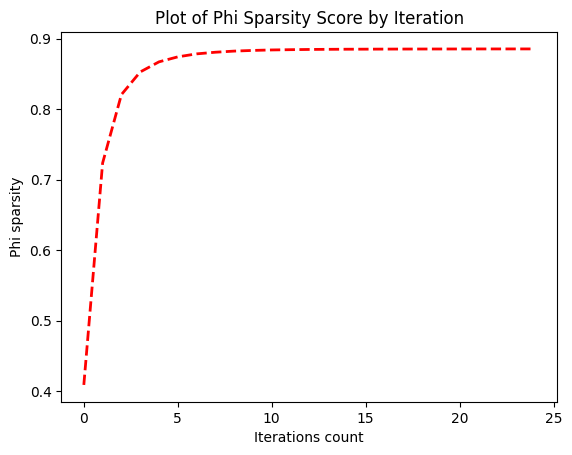

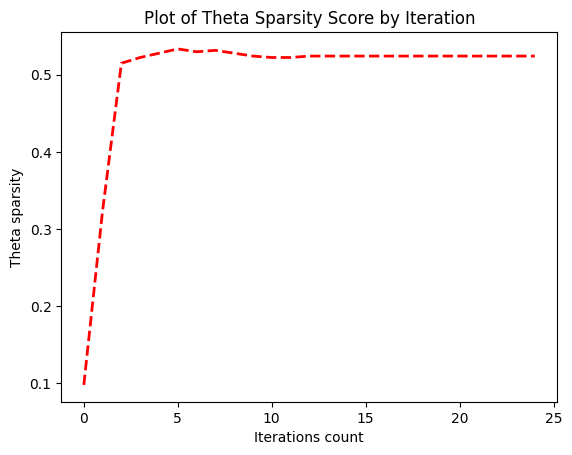

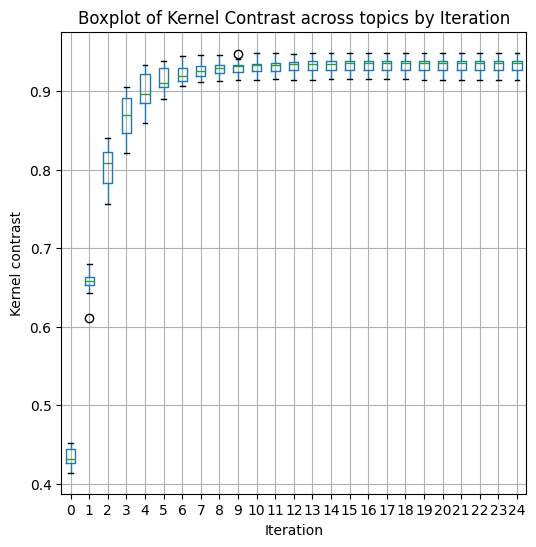

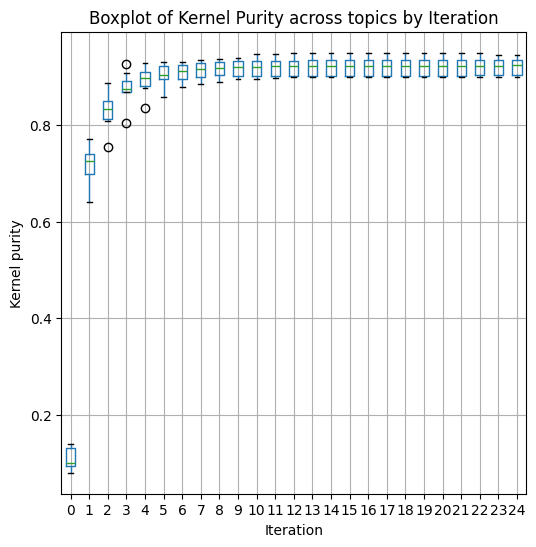

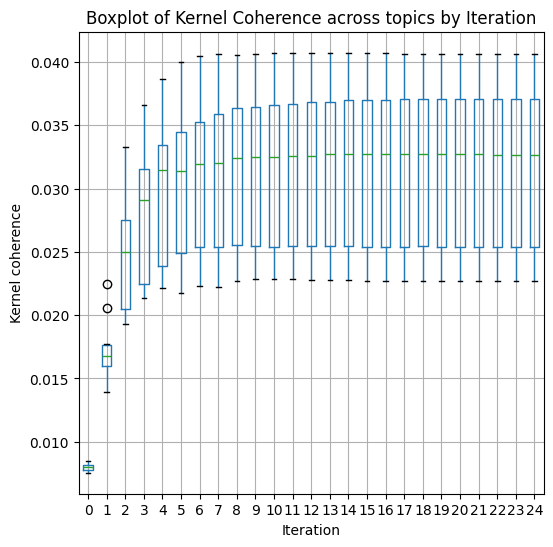

In [37]:
#The way to access score tracker for hARTM models
print_measures(model_artm.get_level(0))

# Note on iterative training process
- This training process will serve as basis to the subsequent development of the hierarchical model
- Coherence calculation requires co-occurence to be calculated prior to modeling
    - revisit preprocessing step
- Regularizers can be added using ```model.regularizers.add```
- Regularizers can not be removed, but can be "turned-off" by setting regularization coefficient value to 0
- The general training procedure is described by Khodorchenko et al., 2020 as follows:

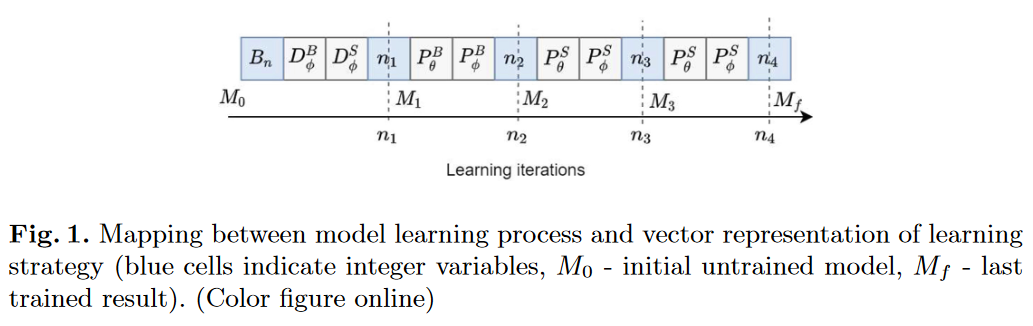

## Suggested hyperparameter search spaces are as follows:
    - B - initial number of topics
    - D - decorrelation regularizer
    - n - number of iterations
    - P - smoothing regularizers
        - B upper index - background topics
        - S upper index - specific topics
        - Phi - topics as token distributions
        - Theta - documents as topic distributions

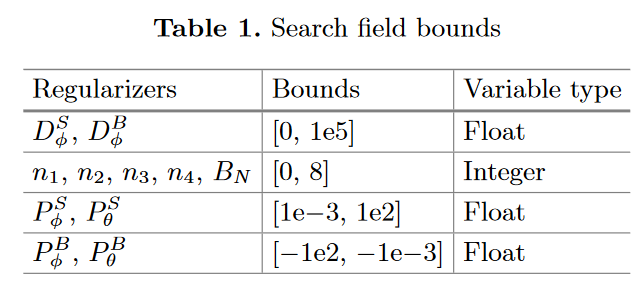

- The differential evolution implementation in Python is possible using the following tool:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html
- Tutorial:
https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/
- Additionally bayesian optimization could be implemented using the following algorithm:
https://github.com/bayesian-optimization/BayesianOptimization

## NLP set - iterative training

In [65]:
#Preparing input
input_folder = '../Data/nlp_set/'
n_gram_value = 1
batch_vectorizer = artm.BatchVectorizer(data_path=f'{input_folder}nlp_set_{n_gram_value}_vw.txt',
                                        data_format='vowpal_wabbit',
                                        target_folder='my_collection_batches')
cooc_dict = artm.Dictionary()
cooc_dict.gather(
    data_path='batches_folder',
    cooc_file_path=f'{input_folder}cooc_{n_gram_value}.txt',
    vocab_file_path=f'{input_folder}vocab_{n_gram_value}.txt',
    symmetric_cooc_values=True)

In [66]:
#defining regularizers
regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
    artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1),
    artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=0),
]

new_regularizers = [
    artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.15),
]
#hyperparameters
num_topics = 5
topic_names = ['topic_{}'.format(i) for i in range(num_topics)]

#defining quality metrics
scores = [
    artm.PerplexityScore(name='PerplexityScore', dictionary=batch_vectorizer.dictionary),
    artm.SparsityPhiScore(name='SparsityPhiScore'),
    artm.SparsityThetaScore(name='SparsityThetaScore'),
    artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3),
    artm.TopTokensScore(name='TopTokensScore', num_tokens=10),
    artm.TopicKernelScore(
        class_id='@default_class',
        name='TopKernelScore Coherence', 
        dictionary=cooc_dict, 
        topic_names=topic_names)
         ]

#creating the model
model_artm = artm.ARTM(topic_names=topic_names, 
                       class_ids = {"@default_class": 1.0, "@bigram": 1.0},
                       cache_theta=True,
                       scores=scores,
                       regularizers=regularizers,
                        num_topics = num_topics)

#EM hyperparameters
n1 = 25
#varying regularization coefficients
model_artm.regularizers['SparsePhi'].tau = -0.2
model_artm.regularizers['SparseTheta'].tau = -20

In [67]:
#First training session
model_artm.initialize(dictionary = cooc_dict)
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n1)

Sparsity Phi: 0.668 
Sparsity Theta: 0.692
Kernel contrast: 0.809
Kernel purity: 0.630


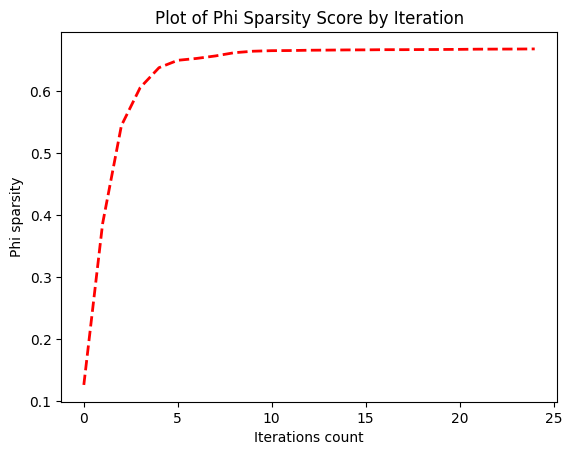

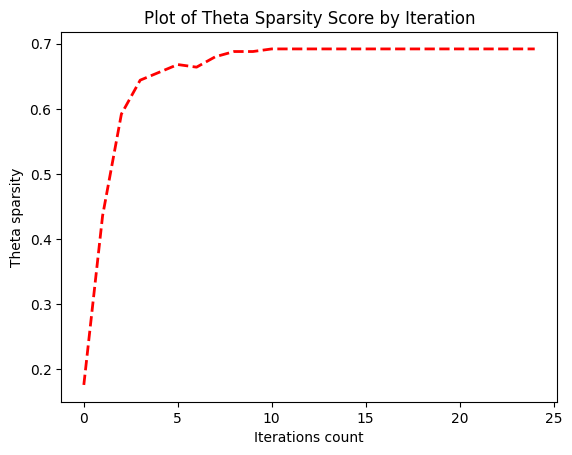

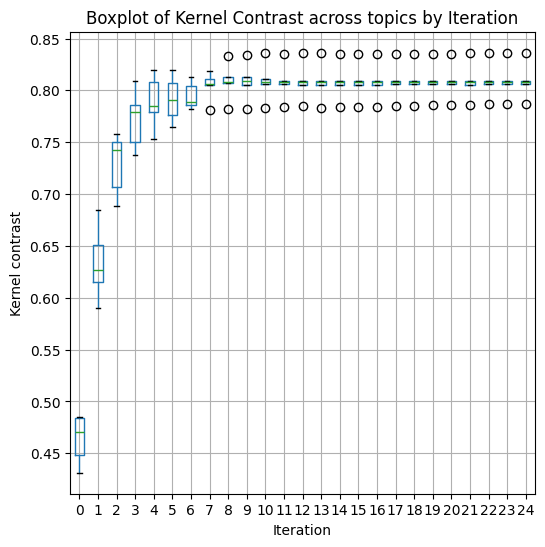

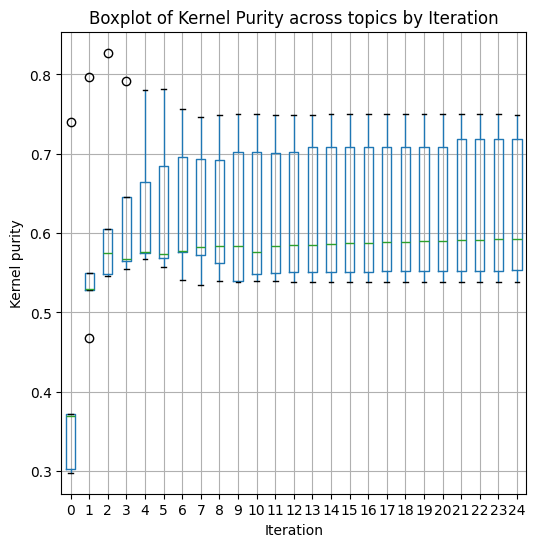

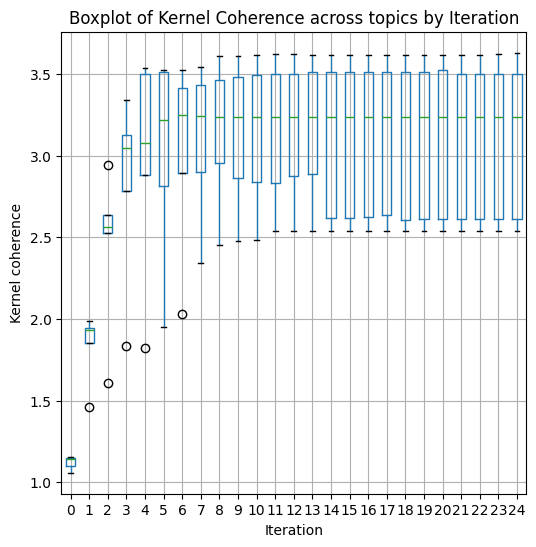

In [68]:
print_measures(model_artm)

In [69]:
#Altering regularizers
model_artm.regularizers['SparsePhi'].tau = 0
model_artm.regularizers['SparseTheta'].tau = 0
model_artm.regularizers['DecorrelatorPhi'].tau = 2.5e+5
n2 = 10

In [70]:
#Second training session
model_artm.fit_offline(
    batch_vectorizer=batch_vectorizer, 
    num_collection_passes=n2)

Sparsity Phi: 0.672 
Sparsity Theta: 0.000
Kernel contrast: 0.830
Kernel purity: 0.811


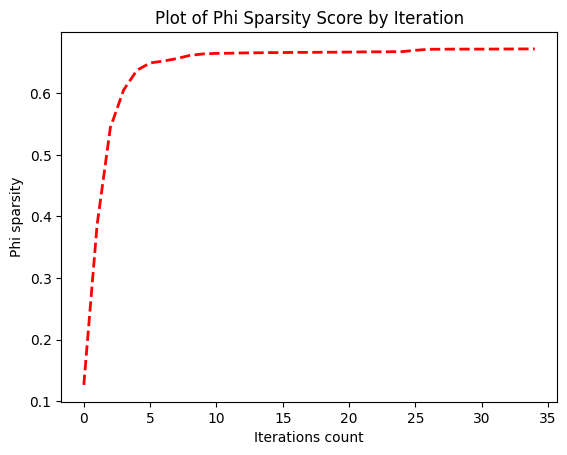

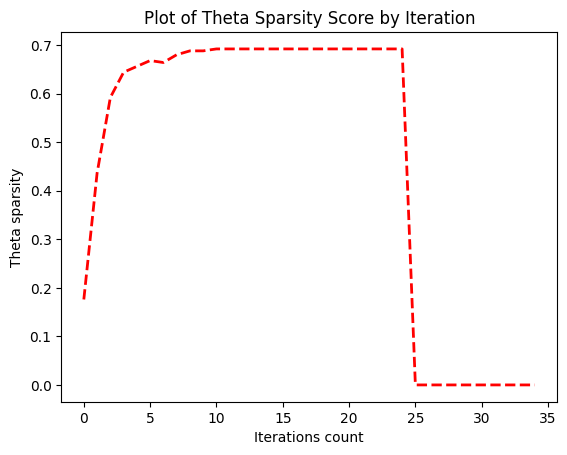

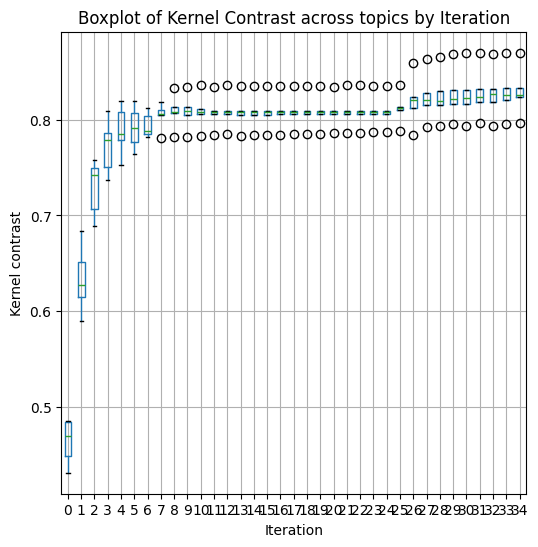

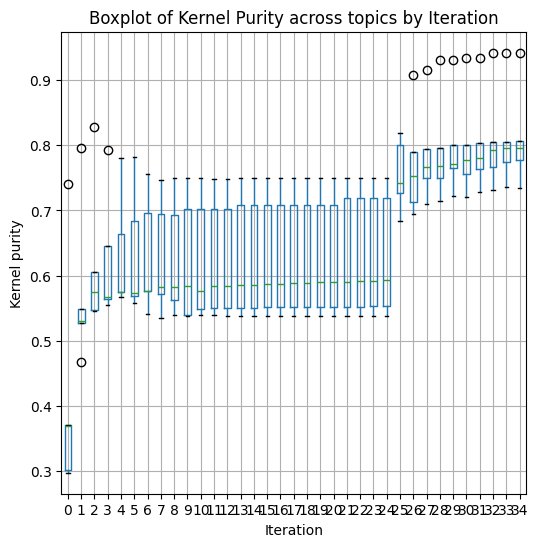

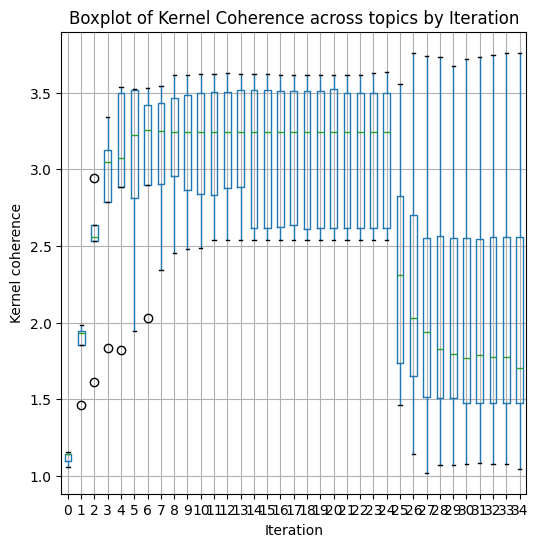

In [71]:
print_measures(model_artm)